In [1]:
###
# META
###

import h5py, bz2, json, re
from tqdm import tqdm_notebook as tqdm
import numpy as np

DATADIR = '/home/mritter/code/twitter_nlp/full_hn_usernames/data/'
NUM_SAMPLES = 100000
SKIP_FIRST = 10000

In [2]:
# download_data.py

# Input
manifest_filename = 'manifest.txt'
server_url = 'https://files.pushshift.io/hackernews/'

# Knobs
test_pct = .5

# Output
raw_data = 'raw_data'


from requests import get

np.random.seed = 42
stop = False
sample_l = []
with open(DATADIR+manifest_filename) as infile:
    for line in tqdm.tqdm(infile):  # Dial
        remote_filename = line.split()[1]
        as_bytes = get(server_url+remote_filename+'.bz2').content
        as_text = bz2.decompress(as_bytes)
        for sample in as_text.split(b'\n'):
            if not len(sample): continue
            sample_l.append(sample.decode("ascii", "ignore"))
            if len(sample_l) >= (SKIP_FIRST + NUM_SAMPLES):
                stop = True
            if stop: break
        if stop: break
            
sample_l = sample_l[SKIP_FIRST:]
np.random.shuffle(sample_l)

14it [00:10,  1.05it/s]

In [3]:
print(sample_l[0])
print('== shuffling ==')
np.random.seed = 42
np.random.shuffle(sample_l)
print(sample_l[0])

{"by":"minus1","id":55529,"parent":55127,"retrieved_on":1525550193,"text":"SlickEdit\n","time":1190001383,"type":"comment"}
== shuffling ==
{"by":"ajju","id":85076,"parent":84959,"retrieved_on":1525554546,"text":"If this isn't just nicely packaged marketing for gmail, it's more likely they are focusing their resources on targets with weaker defenses.\n","time":1196449021,"type":"comment"}


In [4]:
test_ix = int(len(sample_l)*test_pct)

with open(DATADIR+raw_data+'_train.jsonl', 'w') as outfile:
    outfile.write('\n'.join(sample_l[test_ix:]))
        
with open(DATADIR+raw_data+'_test.jsonl', 'w') as outfile:
    outfile.write('\n'.join(sample_l[:test_ix]))

In [5]:
! ls -lah data/*jsonl

-rw-rw-r-- 1 mritter mritter 20M Jan 27 07:21 data/raw_data_test.jsonl
-rw-rw-r-- 1 mritter mritter 20M Jan 27 07:21 data/raw_data_train.jsonl


In [6]:
! wc -l data/*jsonl

   49999 data/raw_data_test.jsonl
   49999 data/raw_data_train.jsonl
   99998 total


In [7]:
! head -1 data/*jsonl

==> data/raw_data_test.jsonl <==
{"by":"ajju","id":85076,"parent":84959,"retrieved_on":1525554546,"text":"If this isn't just nicely packaged marketing for gmail, it's more likely they are focusing their resources on targets with weaker defenses.\n","time":1196449021,"type":"comment"}

==> data/raw_data_train.jsonl <==
{"by":"mudge","descendants":3,"id":82212,"kids":[82217,82312],"retrieved_on":1525554133,"score":1,"text":"","time":1195601405,"title":"Founder\/Hacker Typical Weekend","type":"story","url":"http:\/\/nickmudge.info\/?post=70"}


In [9]:
# preprocess_txt.py

# Input
raw_data = 'raw_data_train.jsonl'

# Knobs
status = 'training'
filter_bool = ('type', 'comment') 
split_regex = r' |\.'
remove_regex = r"\'|\"|,|\.|\n|\/|&#\d\d;|\(|\)"
tag_patterns = {'http.*\w':' <LINK> '}
positive_labels = ('idlewords', 'apaprocki', 'pvg', 'nostrademons', 'patio11', 'carbocation', 'grellas', 'pbsd', 'dctoedt', 'tzs', 'rayiner', 'DannyBee', 'kasey_junk', 'anigbrowl', 'harryh', 'potatolicious', 'mechanical_fish')
sequence_length = 300

# Output
preprocessed_data = 'preprocessed.txt'
label_file = 'label_and_index.h5'

import re

labels = []
original_ids = []

with open(DATADIR+raw_data, 'r') as infile:
    with open(DATADIR+preprocessed_data, 'w') as outfile:
        for line in tqdm.tqdm(infile):  # Dial
            line_json = json.loads(line)

            if line_json[filter_bool[0]] != filter_bool[1]: continue
            try:
                temp_text = line_json['text']
            except KeyError:
                continue
            temp_text = temp_text.lower()
            for key, value in tag_patterns.items():
                temp_text = re.sub(key, value, temp_text)
            text = re.split(split_regex, re.sub(remove_regex, '', temp_text))
            text += ['']*(sequence_length-len(text))
            text += ['\n']
            outfile.write(','.join(text))
            
            if status == 'training':
                labels.append((1, 0) if line_json['by'] in positive_labels else (0, 1))  # Not generalizable
                original_ids.append(line_json['id'])
            
if status == 'training':
    with h5py.File(DATADIR+label_file, "w") as f:
        f.create_dataset('training_labels', (len(labels), 2), dtype='int', data=labels)
        f.create_dataset('ordered_keys', (len(original_ids), 1), dtype='int', data=original_ids)
    


0it [00:00, ?it/s]
3938it [00:00, 39351.23it/s]
7963it [00:00, 39616.07it/s]
12154it [00:00, 40277.07it/s]
16014it [00:00, 39758.39it/s]
19511it [00:00, 38188.76it/s]
23508it [00:00, 38705.01it/s]
27668it [00:00, 39529.42it/s]
31474it [00:00, 39075.77it/s]
35276it [00:00, 38752.77it/s]
39512it [00:01, 39767.02it/s]
43728it [00:01, 40452.85it/s]
47942it [00:01, 40943.26it/s]
50000it [00:01, 39791.01it/s]

In [10]:
!head -2 data/preprocessed.txt

leviticus,19:27,says,in,the,kjv,translation,ye,shall,not,round,the,corners,of,your,heads,neither,shalt,thou,mar,the,corners,of,thy,beard,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
weak!,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,


_insight_: w2v is generated with a simple NN autoencoder

In [11]:
# train_w2v.py

# Input
preprocessed_data = 'preprocessed.txt'

#Knobs
embedding_dim = 2

# Output
w2v_weights_and_word_index_mapping = 'w2v_weights_and_word_index_mapping.h5'

import logging
from gensim.models import Word2Vec

logger= logging.getLogger()  # Dial
logging.basicConfig(format='%(asctime)s : %(levelname)s : %(message)s', level=logging.INFO)


class W2VIter:
    def __init__(self, texts):
        self.texts = texts
    def __iter__(self):
        for text in self.texts:
            yield [token for token in text.split(',') if token != '']

with open(DATADIR+preprocessed_data, 'r') as f:
    w2viter = W2VIter(f.read().split('\n'))

w2v = Word2Vec(w2viter, iter=1, min_count=1, size=embedding_dim, workers=2)

2019-01-27 07:21:46,506 : WARNING : consider setting layer size to a multiple of 4 for greater performance
2019-01-27 07:21:46,506 : INFO : collecting all words and their counts
2019-01-27 07:21:46,507 : INFO : PROGRESS: at sentence #0, processed 0 words, keeping 0 word types
2019-01-27 07:21:46,708 : INFO : PROGRESS: at sentence #10000, processed 503143 words, keeping 37270 word types
2019-01-27 07:21:46,952 : INFO : PROGRESS: at sentence #20000, processed 1007315 words, keeping 59363 word types
2019-01-27 07:21:47,176 : INFO : PROGRESS: at sentence #30000, processed 1501502 words, keeping 77705 word types
2019-01-27 07:21:47,324 : INFO : collected 89663 word types from a corpus of 1858557 raw words and 37055 sentences
2019-01-27 07:21:47,324 : INFO : Loading a fresh vocabulary
2019-01-27 07:21:47,524 : INFO : min_count=1 retains 89663 unique words (100% of original 89663, drops 0)
2019-01-27 07:21:47,524 : INFO : min_count=1 leaves 1858557 word corpus (100% of original 1858557, drops

In [12]:
list(w2v.wv.vocab.keys())[:5]  # Dial

['leviticus', '19:27', 'says', 'in', 'the']

In [18]:
print(w2v.wv['you'][:5])
print(w2v.wv.index2word[0], w2v.wv.index2word[1], w2v.wv.index2word[2])
print('Index of "you" is: {}'.format(w2v.wv.vocab['you'].index))

[-11.13657    5.743102]
the to a
Index of "you" is: 8


(89663, 2)
[[ -9.794257     1.4478339 ]
 [-10.927131     4.013876  ]
 [ -9.785038     2.1536815 ]
 [ -9.639816     0.50508124]
 [-10.126821     1.7449265 ]]


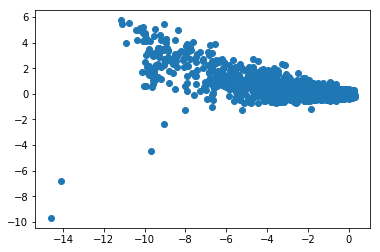

In [19]:
%matplotlib inline
import matplotlib.pyplot as plt

l = []
for i, token in enumerate(w2v.wv.index2word): l.append(w2v.wv[token])
weights = np.array(l)
print(weights.shape)
print(weights[:5, :5])

plt.scatter(weights[:, 0], weights[:, 1])

In [20]:
import h5py

with h5py.File(DATADIR+w2v_weights_and_word_index_mapping, "w") as f:
    f.create_dataset('weights', weights.shape, dtype='f', data=weights)
    for word in tqdm.tqdm(w2v.wv.vocab.keys()):
        f.create_dataset('word_to_index/{}'.format(word), (1,), dtype='int', data=w2v.wv.vocab[word].index)
    f.create_dataset('metadata/embedding_dim', (1,), dtype='int', data=embedding_dim)
    f.create_dataset('metadata/max_token', (1,), dtype='int', data=weights.shape[0]+1)
    f.create_dataset('metadata/sequence_length', (1,), dtype='int', data=sequence_length)



  0%|          | 0/89663 [00:00<?, ?it/s]

  0%|          | 414/89663 [00:00<00:21, 4138.80it/s]

  1%|          | 857/89663 [00:00<00:21, 4219.94it/s]

  1%|▏         | 1340/89663 [00:00<00:20, 4382.17it/s]

  2%|▏         | 1827/89663 [00:00<00:19, 4517.44it/s]

  3%|▎         | 2326/89663 [00:00<00:18, 4648.11it/s]

  3%|▎         | 2802/89663 [00:00<00:18, 4678.60it/s]

  4%|▎         | 3232/89663 [00:00<00:18, 4555.57it/s]

  4%|▍         | 3674/89663 [00:00<00:19, 4511.46it/s]

  5%|▍         | 4103/89663 [00:00<00:19, 4365.41it/s]

  5%|▌         | 4547/89663 [00:01<00:19, 4386.33it/s]

  6%|▌         | 5004/89663 [00:01<00:19, 4438.09it/s]

  6%|▌         | 5448/89663 [00:01<00:18, 4437.60it/s]

  7%|▋         | 5887/89663 [00:01<00:19, 4195.50it/s]

  7%|▋         | 6306/89663 [00:01<00:20, 4149.58it/s]

  7%|▋         | 6721/89663 [00:01<00:21, 3841.31it/s]

  8%|▊         | 7116/89663 [00:01<00:21, 3871.43it/s]

  8%|▊         | 7525/89663 [00:01<00:20, 3932.48it/s]

  9%|

 62%|██████▏   | 55936/89663 [00:13<00:08, 3926.14it/s]

 63%|██████▎   | 56345/89663 [00:13<00:08, 3971.22it/s]

 63%|██████▎   | 56771/89663 [00:13<00:08, 4052.64it/s]

 64%|██████▍   | 57225/89663 [00:13<00:07, 4186.16it/s]

 64%|██████▍   | 57666/89663 [00:13<00:07, 4249.86it/s]

 65%|██████▍   | 58093/89663 [00:13<00:07, 4251.01it/s]

 65%|██████▌   | 58520/89663 [00:13<00:07, 4137.80it/s]

 66%|██████▌   | 58936/89663 [00:14<00:07, 4033.60it/s]

 66%|██████▌   | 59341/89663 [00:14<00:07, 3984.01it/s]

 67%|██████▋   | 59749/89663 [00:14<00:07, 4010.50it/s]

 67%|██████▋   | 60193/89663 [00:14<00:07, 4129.53it/s]

 68%|██████▊   | 60652/89663 [00:14<00:06, 4257.00it/s]

 68%|██████▊   | 61092/89663 [00:14<00:06, 4297.50it/s]

 69%|██████▊   | 61524/89663 [00:14<00:06, 4207.99it/s]

 69%|██████▉   | 61947/89663 [00:14<00:06, 4065.28it/s]

 70%|██████▉   | 62359/89663 [00:14<00:06, 4079.87it/s]

 70%|███████   | 62769/89663 [00:14<00:06, 4052.97it/s]

 70%|███████   | 63176/89663 [0

In [21]:
with h5py.File(DATADIR+w2v_weights_and_word_index_mapping, "r") as f:
    print(list(f['word_to_index'].keys())[:5])
    print(f['word_to_index']['you'][()])

['\t', '\t\t$parsed', '\t\talertthis', '\t\tbsetattributestyle', '\t\treadable_time']
[8]


In [22]:
# index_text.py

# Input
w2v_weights_and_word_index_mapping = 'w2v_weights_and_word_index_mapping.h5'
preprocessed_data = 'preprocessed.txt'

# Knobs
pass

# Output 
indexed_filename = 'indexed.h5'

with h5py.File(DATADIR+w2v_weights_and_word_index_mapping, "r") as index:
    with open(DATADIR+preprocessed_data, "r") as textfile:
        sequence_length = index['metadata']['sequence_length'][0]
        text_lines = textfile.read().split('\n')
        indexed = np.zeros(shape=(len(text_lines)-1, sequence_length))
        keys = index['word_to_index'].keys()
        for line_ix, wordlist in tqdm.tqdm(enumerate(text_lines)):
            for word_ix, word in enumerate(wordlist.split(',')[:sequence_length]):
                if word in keys:
                    indexed[line_ix, word_ix] = index['word_to_index'][word][()]
        
    print(indexed[0, :5])  # Dial

    with h5py.File(DATADIR+indexed_filename, "w") as f:
        f.create_dataset('training_data', 
                         indexed.shape, 
                         dtype='int', data=indexed)



0it [00:00, ?it/s]

8it [00:00, 77.56it/s]

14it [00:00, 70.54it/s]

18it [00:00, 57.16it/s]

28it [00:00, 59.73it/s]

37it [00:00, 65.62it/s]

47it [00:00, 72.38it/s]

54it [00:00, 63.90it/s]

62it [00:00, 67.69it/s]

69it [00:01, 62.49it/s]

77it [00:01, 66.45it/s]

87it [00:01, 71.70it/s]

95it [00:01, 73.35it/s]

104it [00:01, 77.30it/s]

115it [00:01, 84.11it/s]

124it [00:01, 74.06it/s]

132it [00:01, 71.61it/s]

140it [00:02, 57.90it/s]

148it [00:02, 57.90it/s]

158it [00:02, 64.63it/s]

168it [00:02, 68.61it/s]

176it [00:02, 61.95it/s]

183it [00:02, 58.43it/s]

190it [00:02, 58.01it/s]

197it [00:02, 54.74it/s]

207it [00:03, 62.36it/s]

217it [00:03, 69.20it/s]

225it [00:03, 67.92it/s]

234it [00:03, 71.33it/s]

242it [00:03, 57.06it/s]

249it [00:03, 57.17it/s]

257it [00:03, 58.93it/s]

267it [00:04, 64.77it/s]

274it [00:04, 63.47it/s]

281it [00:04, 61.72it/s]

292it [00:04, 62.88it/s]

301it [00:04, 67.07it/s]

312it [00:04, 75.68it/s]

321it [00:04, 74.37it/s]

329

2308it [00:32, 73.76it/s]

2318it [00:32, 79.22it/s]

2327it [00:32, 70.22it/s]

2335it [00:32, 59.09it/s]

2345it [00:33, 67.08it/s]

2353it [00:33, 57.95it/s]

2360it [00:33, 58.12it/s]

2370it [00:33, 65.95it/s]

2382it [00:33, 70.93it/s]

2390it [00:33, 65.21it/s]

2400it [00:33, 69.56it/s]

2408it [00:33, 72.22it/s]

2416it [00:34, 66.48it/s]

2429it [00:34, 77.85it/s]

2438it [00:34, 67.03it/s]

2446it [00:34, 63.74it/s]

2456it [00:34, 67.68it/s]

2467it [00:34, 76.23it/s]

2477it [00:34, 77.04it/s]

2487it [00:34, 81.07it/s]

2499it [00:35, 89.75it/s]

2509it [00:35, 83.42it/s]

2518it [00:35, 76.90it/s]

2531it [00:35, 86.59it/s]

2541it [00:35, 80.96it/s]

2552it [00:35, 86.19it/s]

2564it [00:35, 81.88it/s]

2573it [00:36, 75.56it/s]

2581it [00:36, 75.22it/s]

2589it [00:36, 69.78it/s]

2599it [00:36, 76.52it/s]

2608it [00:36, 78.47it/s]

2617it [00:36, 75.19it/s]

2625it [00:36, 65.03it/s]

2633it [00:36, 68.41it/s]

2645it [00:36, 76.90it/s]

2655it [00:37, 81.55it/s]

2

4588it [01:04, 79.63it/s]

4599it [01:04, 85.37it/s]

4609it [01:04, 89.10it/s]

4622it [01:05, 96.06it/s]

4633it [01:05, 80.14it/s]

4642it [01:05, 81.03it/s]

4651it [01:05, 79.79it/s]

4660it [01:05, 57.87it/s]

4669it [01:05, 63.66it/s]

4677it [01:05, 62.27it/s]

4684it [01:06, 60.84it/s]

4695it [01:06, 69.75it/s]

4703it [01:06, 66.31it/s]

4716it [01:06, 76.79it/s]

4726it [01:06, 80.39it/s]

4735it [01:06, 81.03it/s]

4744it [01:06, 69.22it/s]

4754it [01:06, 75.39it/s]

4764it [01:07, 80.29it/s]

4773it [01:07, 78.81it/s]

4782it [01:07, 73.31it/s]

4791it [01:07, 77.06it/s]

4800it [01:07, 73.68it/s]

4808it [01:07, 68.52it/s]

4819it [01:07, 77.24it/s]

4832it [01:07, 86.07it/s]

4842it [01:08, 66.56it/s]

4850it [01:08, 67.19it/s]

4858it [01:08, 60.04it/s]

4866it [01:08, 62.90it/s]

4873it [01:08, 64.50it/s]

4881it [01:08, 67.06it/s]

4890it [01:08, 72.01it/s]

4902it [01:08, 78.97it/s]

4911it [01:09, 74.97it/s]

4921it [01:09, 79.51it/s]

4931it [01:09, 78.56it/s]

4

6998it [01:36, 68.48it/s]

7008it [01:36, 69.10it/s]

7019it [01:37, 77.00it/s]

7039it [01:37, 93.83it/s]

7051it [01:37, 94.12it/s]

7062it [01:37, 85.82it/s]

7072it [01:37, 87.95it/s]

7082it [01:37, 86.29it/s]

7092it [01:37, 79.23it/s]

7102it [01:37, 83.18it/s]

7111it [01:37, 83.97it/s]

7120it [01:38, 78.45it/s]

7129it [01:38, 67.65it/s]

7137it [01:38, 64.95it/s]

7144it [01:38, 56.48it/s]

7151it [01:38, 58.46it/s]

7158it [01:38, 61.45it/s]

7165it [01:38, 56.06it/s]

7171it [01:39, 53.05it/s]

7177it [01:39, 49.55it/s]

7188it [01:39, 58.01it/s]

7195it [01:39, 57.60it/s]

7203it [01:39, 61.58it/s]

7210it [01:39, 57.94it/s]

7217it [01:39, 49.74it/s]

7223it [01:40, 48.90it/s]

7234it [01:40, 58.43it/s]

7245it [01:40, 62.08it/s]

7252it [01:40, 46.20it/s]

7260it [01:40, 52.30it/s]

7267it [01:40, 54.30it/s]

7274it [01:40, 57.24it/s]

7281it [01:41, 52.62it/s]

7288it [01:41, 52.26it/s]

7294it [01:41, 49.15it/s]

7301it [01:41, 53.02it/s]

7309it [01:41, 58.69it/s]

7

9279it [02:08, 75.53it/s]

9288it [02:08, 79.35it/s]

9300it [02:08, 85.00it/s]

9309it [02:08, 70.68it/s]

9320it [02:09, 76.33it/s]

9329it [02:09, 78.26it/s]

9338it [02:09, 76.16it/s]

9349it [02:09, 82.03it/s]

9361it [02:09, 87.94it/s]

9371it [02:09, 87.57it/s]

9380it [02:09, 78.62it/s]

9389it [02:09, 74.14it/s]

9397it [02:10, 67.88it/s]

9409it [02:10, 76.99it/s]

9418it [02:10, 68.82it/s]

9426it [02:10, 69.90it/s]

9434it [02:10, 72.11it/s]

9442it [02:10, 58.63it/s]

9455it [02:10, 69.90it/s]

9464it [02:10, 71.79it/s]

9474it [02:11, 78.29it/s]

9485it [02:11, 85.33it/s]

9497it [02:11, 93.08it/s]

9509it [02:11, 99.62it/s]

9520it [02:11, 90.36it/s]

9530it [02:11, 84.09it/s]

9539it [02:11, 74.09it/s]

9547it [02:12, 63.34it/s]

9557it [02:12, 66.52it/s]

9565it [02:12, 63.17it/s]

9576it [02:12, 69.17it/s]

9584it [02:12, 71.96it/s]

9596it [02:12, 79.03it/s]

9605it [02:12, 75.26it/s]

9613it [02:12, 58.81it/s]

9620it [02:13, 49.47it/s]

9635it [02:13, 60.72it/s]

9

11601it [02:39, 57.80it/s]

11609it [02:39, 60.84it/s]

11616it [02:40, 50.66it/s]

11622it [02:40, 42.17it/s]

11627it [02:40, 42.76it/s]

11635it [02:40, 48.87it/s]

11641it [02:40, 50.97it/s]

11647it [02:40, 52.72it/s]

11655it [02:40, 53.17it/s]

11663it [02:41, 55.45it/s]

11669it [02:41, 56.37it/s]

11678it [02:41, 62.12it/s]

11686it [02:41, 65.67it/s]

11693it [02:41, 61.38it/s]

11702it [02:41, 64.07it/s]

11709it [02:41, 65.63it/s]

11718it [02:41, 70.96it/s]

11731it [02:41, 81.83it/s]

11743it [02:42, 90.41it/s]

11753it [02:42, 79.78it/s]

11762it [02:42, 82.48it/s]

11771it [02:42, 79.04it/s]

11780it [02:42, 75.45it/s]

11789it [02:42, 78.08it/s]

11798it [02:42, 73.18it/s]

11806it [02:42, 68.04it/s]

11817it [02:43, 72.89it/s]

11825it [02:43, 72.81it/s]

11837it [02:43, 82.48it/s]

11853it [02:43, 95.67it/s]

11864it [02:43, 72.65it/s]

11873it [02:43, 74.69it/s]

11883it [02:43, 78.92it/s]

11892it [02:43, 79.31it/s]

11901it [02:44, 82.06it/s]

11910it [02:44, 77.0

13790it [03:10, 76.27it/s]

13798it [03:10, 68.06it/s]

13808it [03:10, 74.85it/s]

13819it [03:10, 82.40it/s]

13828it [03:11, 80.85it/s]

13837it [03:11, 75.27it/s]

13849it [03:11, 84.64it/s]

13859it [03:11, 74.88it/s]

13869it [03:11, 80.02it/s]

13878it [03:11, 75.68it/s]

13887it [03:11, 72.37it/s]

13895it [03:11, 66.19it/s]

13904it [03:12, 71.77it/s]

13912it [03:12, 73.50it/s]

13920it [03:12, 71.47it/s]

13928it [03:12, 63.43it/s]

13938it [03:12, 69.61it/s]

13947it [03:12, 66.13it/s]

13957it [03:12, 72.72it/s]

13969it [03:12, 82.43it/s]

13979it [03:12, 86.91it/s]

13995it [03:13, 100.47it/s]

14007it [03:13, 87.63it/s] 

14017it [03:13, 80.86it/s]

14026it [03:13, 78.67it/s]

14035it [03:13, 70.45it/s]

14043it [03:13, 72.31it/s]

14053it [03:13, 75.08it/s]

14063it [03:14, 78.59it/s]

14072it [03:14, 77.33it/s]

14080it [03:14, 67.42it/s]

14088it [03:14, 57.98it/s]

14095it [03:14, 58.33it/s]

14107it [03:14, 65.06it/s]

14115it [03:14, 66.70it/s]

14123it [03:14, 63

16106it [03:41, 80.84it/s]

16116it [03:41, 82.97it/s]

16130it [03:41, 90.05it/s]

16140it [03:42, 91.70it/s]

16150it [03:42, 72.64it/s]

16159it [03:42, 68.89it/s]

16169it [03:42, 72.82it/s]

16177it [03:42, 71.15it/s]

16185it [03:42, 69.38it/s]

16193it [03:42, 66.35it/s]

16205it [03:43, 76.30it/s]

16214it [03:43, 76.05it/s]

16223it [03:43, 68.96it/s]

16231it [03:43, 59.43it/s]

16238it [03:43, 60.35it/s]

16245it [03:43, 60.71it/s]

16259it [03:43, 68.92it/s]

16271it [03:43, 75.50it/s]

16280it [03:44, 78.27it/s]

16289it [03:44, 77.60it/s]

16299it [03:44, 80.95it/s]

16308it [03:44, 80.84it/s]

16324it [03:44, 94.47it/s]

16335it [03:44, 85.60it/s]

16345it [03:44, 85.05it/s]

16355it [03:44, 84.90it/s]

16364it [03:45, 80.26it/s]

16373it [03:45, 72.00it/s]

16381it [03:45, 62.01it/s]

16388it [03:45, 60.36it/s]

16396it [03:45, 64.26it/s]

16403it [03:45, 61.25it/s]

16415it [03:45, 71.23it/s]

16426it [03:45, 79.60it/s]

16435it [03:46, 81.16it/s]

16444it [03:46, 79.7

18409it [04:12, 96.08it/s]

18420it [04:12, 82.96it/s]

18430it [04:12, 83.37it/s]

18440it [04:12, 86.89it/s]

18450it [04:12, 81.35it/s]

18461it [04:13, 86.56it/s]

18471it [04:13, 82.16it/s]

18480it [04:13, 76.89it/s]

18488it [04:13, 68.26it/s]

18496it [04:13, 61.61it/s]

18507it [04:13, 67.80it/s]

18517it [04:13, 73.73it/s]

18529it [04:13, 83.35it/s]

18539it [04:14, 72.21it/s]

18548it [04:14, 66.39it/s]

18556it [04:14, 63.01it/s]

18565it [04:14, 68.66it/s]

18573it [04:14, 64.99it/s]

18580it [04:14, 58.76it/s]

18588it [04:14, 63.26it/s]

18595it [04:15, 61.14it/s]

18602it [04:15, 57.12it/s]

18610it [04:15, 62.03it/s]

18617it [04:15, 54.82it/s]

18626it [04:15, 60.95it/s]

18633it [04:15, 56.15it/s]

18640it [04:15, 55.45it/s]

18649it [04:15, 62.25it/s]

18660it [04:16, 71.46it/s]

18668it [04:16, 65.45it/s]

18676it [04:16, 58.75it/s]

18683it [04:16, 54.72it/s]

18690it [04:16, 56.93it/s]

18701it [04:16, 65.29it/s]

18710it [04:16, 69.30it/s]

18718it [04:17, 45.9

20607it [04:43, 76.78it/s]

20616it [04:43, 71.97it/s]

20627it [04:43, 75.76it/s]

20639it [04:43, 84.99it/s]

20656it [04:43, 99.31it/s]

20668it [04:43, 97.60it/s]

20679it [04:43, 91.63it/s]

20689it [04:43, 81.21it/s]

20698it [04:44, 75.67it/s]

20707it [04:44, 73.43it/s]

20718it [04:44, 79.85it/s]

20729it [04:44, 84.49it/s]

20738it [04:44, 76.60it/s]

20747it [04:44, 77.65it/s]

20756it [04:44, 76.76it/s]

20764it [04:44, 72.42it/s]

20773it [04:45, 72.15it/s]

20783it [04:45, 77.63it/s]

20795it [04:45, 86.32it/s]

20805it [04:45, 87.12it/s]

20815it [04:45, 90.22it/s]

20825it [04:45, 92.55it/s]

20835it [04:45, 84.93it/s]

20846it [04:45, 90.58it/s]

20856it [04:45, 90.50it/s]

20866it [04:46, 81.61it/s]

20877it [04:46, 87.23it/s]

20887it [04:46, 85.25it/s]

20896it [04:46, 71.06it/s]

20906it [04:46, 77.40it/s]

20919it [04:46, 80.05it/s]

20928it [04:46, 82.30it/s]

20937it [04:46, 77.09it/s]

20947it [04:47, 82.59it/s]

20959it [04:47, 90.47it/s]

20969it [04:47, 91.6

22864it [05:14, 68.94it/s]

22872it [05:14, 64.50it/s]

22881it [05:14, 69.40it/s]

22890it [05:14, 74.39it/s]

22898it [05:15, 62.67it/s]

22906it [05:15, 64.75it/s]

22920it [05:15, 76.74it/s]

22929it [05:15, 56.79it/s]

22937it [05:15, 51.28it/s]

22945it [05:15, 56.86it/s]

22952it [05:16, 46.85it/s]

22958it [05:16, 42.47it/s]

22966it [05:16, 49.19it/s]

22975it [05:16, 56.91it/s]

22982it [05:16, 47.21it/s]

22988it [05:16, 47.86it/s]

22997it [05:16, 55.02it/s]

23006it [05:16, 62.01it/s]

23014it [05:17, 63.57it/s]

23022it [05:17, 53.69it/s]

23029it [05:17, 54.84it/s]

23036it [05:17, 54.93it/s]

23044it [05:17, 59.57it/s]

23051it [05:17, 58.08it/s]

23058it [05:17, 59.44it/s]

23065it [05:17, 58.86it/s]

23078it [05:18, 69.86it/s]

23086it [05:18, 69.38it/s]

23097it [05:18, 73.57it/s]

23105it [05:18, 64.44it/s]

23116it [05:18, 72.33it/s]

23125it [05:18, 69.97it/s]

23133it [05:18, 69.11it/s]

23141it [05:18, 63.19it/s]

23148it [05:19, 58.56it/s]

23157it [05:19, 61.7

25059it [05:45, 77.88it/s]

25068it [05:46, 75.08it/s]

25078it [05:46, 79.17it/s]

25087it [05:46, 71.90it/s]

25095it [05:46, 71.67it/s]

25103it [05:46, 69.17it/s]

25113it [05:46, 68.05it/s]

25120it [05:46, 62.21it/s]

25127it [05:47, 59.82it/s]

25136it [05:47, 57.92it/s]

25146it [05:47, 63.51it/s]

25157it [05:47, 63.20it/s]

25164it [05:47, 55.00it/s]

25176it [05:47, 65.57it/s]

25184it [05:47, 53.84it/s]

25194it [05:48, 62.45it/s]

25208it [05:48, 74.11it/s]

25218it [05:48, 56.63it/s]

25226it [05:48, 61.61it/s]

25235it [05:48, 66.60it/s]

25243it [05:48, 69.81it/s]

25251it [05:48, 71.61it/s]

25261it [05:48, 77.69it/s]

25270it [05:49, 70.84it/s]

25278it [05:49, 59.30it/s]

25286it [05:49, 63.52it/s]

25293it [05:49, 47.19it/s]

25299it [05:49, 47.44it/s]

25307it [05:49, 53.47it/s]

25314it [05:49, 54.36it/s]

25320it [05:50, 55.11it/s]

25326it [05:50, 55.04it/s]

25335it [05:50, 62.04it/s]

25344it [05:50, 67.33it/s]

25352it [05:50, 67.61it/s]

25360it [05:50, 70.0

27383it [06:16, 73.29it/s]

27391it [06:16, 70.15it/s]

27405it [06:16, 80.45it/s]

27418it [06:17, 79.04it/s]

27427it [06:17, 77.86it/s]

27438it [06:17, 84.95it/s]

27447it [06:17, 86.03it/s]

27456it [06:17, 74.14it/s]

27464it [06:17, 65.14it/s]

27472it [06:17, 63.72it/s]

27479it [06:17, 65.10it/s]

27489it [06:18, 65.49it/s]

27502it [06:18, 72.76it/s]

27513it [06:18, 79.83it/s]

27522it [06:18, 70.33it/s]

27530it [06:18, 69.04it/s]

27539it [06:18, 73.00it/s]

27547it [06:18, 74.36it/s]

27556it [06:18, 77.22it/s]

27566it [06:18, 80.39it/s]

27578it [06:19, 80.66it/s]

27587it [06:19, 62.31it/s]

27594it [06:19, 63.29it/s]

27601it [06:19, 57.81it/s]

27608it [06:19, 59.58it/s]

27615it [06:19, 62.31it/s]

27622it [06:19, 59.19it/s]

27629it [06:20, 61.29it/s]

27639it [06:20, 69.26it/s]

27647it [06:20, 69.82it/s]

27655it [06:20, 65.04it/s]

27662it [06:20, 60.57it/s]

27669it [06:20, 58.43it/s]

27677it [06:20, 63.51it/s]

27684it [06:20, 63.06it/s]

27695it [06:21, 68.0

29770it [06:47, 68.56it/s]

29779it [06:47, 73.58it/s]

29788it [06:47, 76.24it/s]

29796it [06:47, 75.35it/s]

29804it [06:47, 76.51it/s]

29812it [06:47, 68.82it/s]

29820it [06:47, 57.75it/s]

29835it [06:47, 70.59it/s]

29844it [06:48, 58.04it/s]

29853it [06:48, 64.00it/s]

29861it [06:48, 58.98it/s]

29872it [06:48, 67.86it/s]

29881it [06:48, 70.40it/s]

29889it [06:48, 65.78it/s]

29898it [06:48, 63.30it/s]

29911it [06:49, 70.07it/s]

29919it [06:49, 71.51it/s]

29930it [06:49, 78.50it/s]

29939it [06:49, 72.58it/s]

29949it [06:49, 76.75it/s]

29959it [06:49, 79.57it/s]

29969it [06:49, 81.36it/s]

29983it [06:49, 90.59it/s]

29993it [06:50, 89.12it/s]

30003it [06:50, 73.60it/s]

30012it [06:50, 62.92it/s]

30020it [06:50, 66.02it/s]

30028it [06:50, 57.89it/s]

30035it [06:50, 56.15it/s]

30042it [06:50, 57.87it/s]

30049it [06:51, 44.03it/s]

30057it [06:51, 50.44it/s]

30063it [06:51, 50.26it/s]

30072it [06:51, 57.54it/s]

30079it [06:51, 57.97it/s]

30086it [06:51, 60.3

32005it [07:18, 49.46it/s]

32013it [07:18, 55.03it/s]

32023it [07:18, 63.50it/s]

32035it [07:18, 73.34it/s]

32044it [07:18, 70.53it/s]

32053it [07:19, 72.76it/s]

32064it [07:19, 74.21it/s]

32072it [07:19, 64.05it/s]

32079it [07:19, 62.93it/s]

32088it [07:19, 69.07it/s]

32099it [07:19, 75.82it/s]

32116it [07:19, 90.15it/s]

32127it [07:19, 84.08it/s]

32137it [07:20, 71.70it/s]

32146it [07:20, 70.77it/s]

32154it [07:20, 61.00it/s]

32163it [07:20, 66.01it/s]

32171it [07:20, 66.77it/s]

32179it [07:20, 69.50it/s]

32187it [07:20, 67.14it/s]

32194it [07:21, 55.15it/s]

32201it [07:21, 58.79it/s]

32211it [07:21, 66.89it/s]

32219it [07:21, 59.18it/s]

32227it [07:21, 63.84it/s]

32236it [07:21, 69.68it/s]

32245it [07:21, 74.20it/s]

32253it [07:21, 65.34it/s]

32261it [07:22, 65.18it/s]

32268it [07:22, 62.52it/s]

32278it [07:22, 68.35it/s]

32287it [07:22, 70.07it/s]

32295it [07:22, 60.13it/s]

32302it [07:22, 60.46it/s]

32310it [07:22, 65.07it/s]

32325it [07:22, 77.1

34251it [07:49, 86.32it/s]

34261it [07:50, 72.56it/s]

34273it [07:50, 82.12it/s]

34283it [07:50, 72.95it/s]

34295it [07:50, 81.32it/s]

34305it [07:50, 82.37it/s]

34314it [07:50, 77.72it/s]

34325it [07:50, 82.66it/s]

34335it [07:50, 86.50it/s]

34345it [07:51, 88.13it/s]

34355it [07:51, 85.73it/s]

34365it [07:51, 86.53it/s]

34375it [07:51, 86.44it/s]

34384it [07:51, 85.96it/s]

34395it [07:51, 90.67it/s]

34410it [07:51, 96.32it/s]

34421it [07:51, 98.64it/s]

34432it [07:51, 86.29it/s]

34443it [07:52, 88.66it/s]

34453it [07:52, 87.55it/s]

34462it [07:52, 69.97it/s]

34474it [07:52, 78.99it/s]

34483it [07:52, 77.87it/s]

34499it [07:52, 85.30it/s]

34509it [07:52, 74.84it/s]

34519it [07:53, 77.61it/s]

34531it [07:53, 86.53it/s]

34541it [07:53, 78.95it/s]

34552it [07:53, 85.05it/s]

34562it [07:53, 81.81it/s]

34575it [07:53, 89.37it/s]

34585it [07:53, 90.87it/s]

34597it [07:53, 97.11it/s]

34608it [07:54, 84.62it/s]

34618it [07:54, 71.49it/s]

34629it [07:54, 70.0

36597it [08:21, 63.91it/s]

36604it [08:21, 64.42it/s]

36611it [08:21, 52.77it/s]

36617it [08:21, 53.77it/s]

36623it [08:21, 50.34it/s]

36632it [08:21, 57.35it/s]

36639it [08:21, 53.35it/s]

36649it [08:22, 55.86it/s]

36655it [08:22, 56.73it/s]

36662it [08:22, 59.17it/s]

36671it [08:22, 57.25it/s]

36681it [08:22, 63.89it/s]

36694it [08:22, 74.49it/s]

36703it [08:22, 64.83it/s]

36711it [08:23, 63.08it/s]

36718it [08:23, 63.08it/s]

36731it [08:23, 73.31it/s]

36740it [08:23, 75.15it/s]

36749it [08:23, 62.49it/s]

36757it [08:23, 59.70it/s]

36764it [08:23, 56.24it/s]

36771it [08:24, 46.56it/s]

36777it [08:24, 44.64it/s]

36782it [08:24, 43.87it/s]

36788it [08:24, 46.11it/s]

36798it [08:24, 53.57it/s]

36804it [08:24, 54.94it/s]

36812it [08:24, 57.12it/s]

36819it [08:24, 57.97it/s]

36826it [08:25, 44.09it/s]

36834it [08:25, 50.37it/s]

36842it [08:25, 56.03it/s]

36849it [08:25, 54.25it/s]

36855it [08:25, 48.52it/s]

36861it [08:25, 51.01it/s]

36872it [08:25, 56.1

[2.9518e+04 2.9519e+04 5.0200e+02 9.0000e+00 0.0000e+00]


In [23]:
# model.py

# Inputs
w2v_weights_and_word_index_mapping = 'w2v_weights_and_word_index_mapping.h5'
training_file = 'indexed.h5'

# Knobs
pass  # The whole thing, to some extent

# Outputs
compiled_model = 'compiled_model.keras'


with h5py.File(DATADIR+w2v_weights_and_word_index_mapping, "r") as f:
    embedding_matrix = f['weights'][()]
    embedding_dim = f['metadata/embedding_dim'][0]
    num_distinct_words = f['metadata/max_token'][0]
    sequence_length = f['metadata/sequence_length'][0]
    
from keras.models import Sequential
from keras.layers import Dense, Input, Embedding, Flatten
from keras.initializers import Constant
from keras.models import Model


sequence_input = Input(shape=(sequence_length,), dtype='int32')

embedded_sequences = Embedding(num_distinct_words,
                            embedding_dim,
                            embeddings_initializer=Constant(embedding_matrix),
                            input_length=sequence_length,
                            trainable=False)(sequence_input)

x = Dense(units=64, activation='relu')(embedded_sequences)
x = Dense(units=32, activation='relu')(embedded_sequences)
x = Flatten()(x)
preds = Dense(units=2, activation='softmax')(x)

model = Model(sequence_input, preds)
model.compile(loss='categorical_crossentropy',
              optimizer='sgd',
              metrics=['accuracy'])

print(model.summary())  # Dial
model.save(DATADIR+compiled_model)

Using TensorFlow backend.


_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 300)               0         
_________________________________________________________________
embedding_1 (Embedding)      (None, 300, 2)            179328    
_________________________________________________________________
dense_2 (Dense)              (None, 300, 32)           96        
_________________________________________________________________
flatten_1 (Flatten)          (None, 9600)              0         
_________________________________________________________________
dense_3 (Dense)              (None, 2)                 19202     
Total params: 198,626
Trainable params: 19,298
Non-trainable params: 179,328
_________________________________________________________________
None


In [24]:
# train.py

# Input
training_file = 'indexed.h5'
label_file = 'label_and_index.h5'

# Knobs
epochs = 5
batch_size = 64

# Output
compiled_model = 'compiled_model.keras'
trained_model = 'trained_model.yaml'
trained_weights = 'trained_weights.h5'

from keras.callbacks import TensorBoard as tb
from datetime import datetime
t = datetime.now()
tensorboard = tb(log_dir='tensorboard_logs/{:%Y-%m-%d-%H-%M}'.format(t))  # Dial

with h5py.File(DATADIR+training_file, "r") as f1:
    with h5py.File(DATADIR+label_file, "r") as f2:
        x_train = f1['training_data']  # Note that Keras is special in being able to read the HDF5 _object_
        y_train = f2['training_labels']
        
        model.fit(x_train, y_train,
                  batch_size=batch_size,
                  epochs=epochs,
                  shuffle='batch',  # Required for using HDF5
                  callbacks=[tensorboard])

# serialize model to YAML
# From https://machinelearningmastery.com/save-load-keras-deep-learning-models/
model_yaml = model.to_yaml()
with open(DATADIR+trained_model, "w") as yaml_file:
    yaml_file.write(model_yaml)
# serialize weights to HDF5
model.save_weights(DATADIR+trained_weights)
print("Saved model to disk")


Epoch 1/5
37054/37054 [==============================] - 9s 254us/step - loss: 0.2007 - acc: 0.9858
Epoch 2/5
37054/37054 [==============================] - 9s 248us/step - loss: 0.2005 - acc: 0.9876
Epoch 3/5
37054/37054 [==============================] - 9s 232us/step - loss: 0.2005 - acc: 0.9876
Epoch 4/5
37054/37054 [==============================] - 8s 228us/step - loss: 0.2005 - acc: 0.9876
Epoch 5/5
37054/37054 [==============================] - 8s 208us/step - loss: 0.2005 - acc: 0.9876
Saved model to disk


In [25]:
# inference.py

# Input
comments_text = ["""
Reminder, if you're in the US, the FTC says your eye doctor must give you your prescription after your exam. If a doctor refuses to do so, they can face legal action and penalties.

https://www.consumer.ftc.gov/blog/2016/05/buying-prescriptio...

That said, I don't think the FTC stipulates what information must appear on the prescription. Many docs leave off your PD (pupillary distance), which is a necessary measurement if you're buying online. Fortunately, there are a variety of easy ways to take this measurement yourself after the exam, although if you're really concerned about precision, you'll want the doctor's measurement.

And by the way, it should go without saying, but I'll say it anyway. Although the quality of eyewear available online can be comparable to what you'd get in store ... please don't think an online eye exam is an acceptable substitute for visiting an ophthalmologist in person and getting a comprehensive eye exam! 
"""]  # This will eventually be an API call
trained_model = 'trained_model.yaml'
trained_weights = 'trained_weights.h5'
w2v_weights_and_word_index_mapping = 'w2v_weights_and_word_index_mapping.h5'

# Knobs
pass

# Output
pass  # Print to command line

from keras.models import model_from_yaml

# load YAML and create model
with open(DATADIR+trained_model, 'r') as yaml_file:
    loaded_model_yaml = yaml_file.read()
    loaded_model = model_from_yaml(loaded_model_yaml)

# load weights into new model
loaded_model.load_weights(DATADIR+trained_weights)
print("Loaded model from disk")


# preprocess (will eventually be call to same function)

split_regex = r' |\.'
remove_regex = r"\'|\"|,|\.|\n|\/|&#\d\d;|\(|\)"
tag_patterns = {'http.*\w':' <LINK> '}
positive_labels = ('pg', 'patio11', 'volida')
sequence_length = 300

pp_str = ''
for line in tqdm.tqdm(comments_text):  # Dial
    temp_text = line
    temp_text = temp_text.lower()
    for key, value in tag_patterns.items():
        temp_text = re.sub(key, value, temp_text)
    text = re.split(split_regex, re.sub(remove_regex, '', temp_text))
    print(len(text))
    text += ['']*(sequence_length-len(text))
    text += ['\n']
    pp_str += ','.join(text)

    
    
with h5py.File(DATADIR+w2v_weights_and_word_index_mapping, "r") as index:       
    text_lines = pp_str.split('\n')
    indexed = np.zeros(shape=(len(text_lines)-1, index['metadata']['sequence_length'][0]))
    keys = index['word_to_index'].keys()
    for line_ix, wordlist in enumerate(text_lines):
        for word_ix, word in enumerate(wordlist.split(',')):
            if word in keys:
                indexed[line_ix, word_ix] = index['word_to_index'][word][()]
    
loaded_model.predict(indexed)[0, 0]



  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:00<00:00, 1019.02it/s]

Loaded model from disk
149


0.0

In [27]:
# test.py

# Call all the same 

test_filename = 'downloaded_test'
trained_model = 'trained_model'

# Input
raw_data = 'raw_data_test.jsonl'

# Knobs
status = 'training'
filter_bool = ('type', 'comment') 
split_regex = r' |\.'
remove_regex = r"\'|\"|,|\.|\n|\/|&#\d\d;|\(|\)"
tag_patterns = {'http.*\w':' <LINK> '}
sequence_length = 300

# Output
pass  # Print

actual_labels = []
original_ids = []
outfile_text = ''

with open(DATADIR+raw_data, 'r') as infile:
    with open(DATADIR+preprocessed_data, 'w') as outfile:
        for line in tqdm.tqdm(infile):  # Dial
            line_json = json.loads(line)

            if line_json[filter_bool[0]] != filter_bool[1]: continue
            try:
                temp_text = line_json['text']
            except KeyError:
                continue
            temp_text = temp_text.lower()
            for key, value in tag_patterns.items():
                temp_text = re.sub(key, value, temp_text)
            text = re.split(split_regex, re.sub(remove_regex, '', temp_text))
            text += ['']*(sequence_length-len(text))
            text += ['\n']
            outfile_text += ','.join(text)
            
            actual_labels.append(line_json['by'])
            
            
with h5py.File(DATADIR+w2v_weights_and_word_index_mapping, "r") as index:       
    text_lines = outfile_text.split('\n')
    sequence_length = index['metadata']['sequence_length'][0]
    indexed = np.zeros(shape=(len(text_lines)-1, sequence_length))
    keys = index['word_to_index'].keys()
    for line_ix, wordlist in tqdm.tqdm(enumerate(text_lines)):
        for word_ix, word in enumerate(wordlist.split(',')[:sequence_length]):
            if word in keys:
                indexed[line_ix, word_ix] = index['word_to_index'][word][()]
    
preds = loaded_model.predict(indexed)
preds.max(axis=0)
# print(actual_labels)



0it [00:00, ?it/s]

3939it [00:00, 39366.20it/s]

8195it [00:00, 40270.19it/s]

12494it [00:00, 41045.36it/s]

16697it [00:00, 41335.77it/s]

20768it [00:00, 41144.52it/s]

24968it [00:00, 41396.12it/s]

28648it [00:00, 39840.52it/s]

32571it [00:00, 39655.21it/s]

36621it [00:00, 39904.43it/s]

40748it [00:01, 40302.53it/s]

44813it [00:01, 40405.12it/s]

48935it [00:01, 40645.39it/s]

50000it [00:01, 40723.14it/s]

0it [00:00, ?it/s]

6it [00:00, 47.62it/s]

15it [00:00, 53.00it/s]

23it [00:00, 54.02it/s]

27it [00:00, 44.59it/s]

32it [00:00, 46.09it/s]

44it [00:00, 56.37it/s]

52it [00:00, 60.43it/s]

59it [00:00, 57.15it/s]

71it [00:01, 63.91it/s]

79it [00:01, 65.30it/s]

87it [00:01, 68.98it/s]

95it [00:01, 57.92it/s]

104it [00:01, 61.84it/s]

113it [00:01, 67.77it/s]

125it [00:01, 77.87it/s]

135it [00:01, 82.81it/s]

144it [00:02, 60.38it/s]

155it [00:02, 68.88it/s]

169it [00:02, 80.03it/s]

179it [00:02, 83.46it/s]

189it [00:02, 74.72it/s]

198it [00:02, 65.13it/s]

2182it [00:30, 61.70it/s]

2189it [00:30, 62.63it/s]

2196it [00:30, 64.06it/s]

2203it [00:30, 56.84it/s]

2217it [00:30, 69.07it/s]

2228it [00:30, 77.45it/s]

2238it [00:31, 76.87it/s]

2249it [00:31, 79.87it/s]

2258it [00:31, 77.73it/s]

2267it [00:31, 73.59it/s]

2275it [00:31, 73.69it/s]

2286it [00:31, 77.99it/s]

2296it [00:31, 82.34it/s]

2305it [00:31, 65.27it/s]

2313it [00:32, 58.66it/s]

2321it [00:32, 58.34it/s]

2328it [00:32, 47.61it/s]

2335it [00:32, 50.69it/s]

2343it [00:32, 48.87it/s]

2349it [00:32, 51.65it/s]

2355it [00:33, 43.05it/s]

2360it [00:33, 44.18it/s]

2368it [00:33, 50.99it/s]

2374it [00:33, 44.08it/s]

2379it [00:33, 45.54it/s]

2386it [00:33, 48.47it/s]

2393it [00:33, 51.06it/s]

2399it [00:33, 41.25it/s]

2407it [00:34, 47.93it/s]

2417it [00:34, 54.06it/s]

2424it [00:34, 50.06it/s]

2430it [00:34, 48.17it/s]

2436it [00:34, 42.77it/s]

2444it [00:34, 43.31it/s]

2452it [00:35, 46.79it/s]

2459it [00:35, 48.14it/s]

2465it [00:35, 48.46it/s]

2

4530it [01:02, 83.61it/s]

4539it [01:02, 76.21it/s]

4549it [01:02, 80.23it/s]

4558it [01:02, 68.27it/s]

4566it [01:02, 70.36it/s]

4574it [01:02, 66.46it/s]

4585it [01:03, 74.74it/s]

4595it [01:03, 76.41it/s]

4605it [01:03, 82.06it/s]

4614it [01:03, 79.97it/s]

4630it [01:03, 93.90it/s]

4641it [01:03, 80.78it/s]

4651it [01:03, 72.72it/s]

4661it [01:03, 74.81it/s]

4670it [01:04, 75.06it/s]

4681it [01:04, 81.95it/s]

4690it [01:04, 77.56it/s]

4699it [01:04, 71.72it/s]

4712it [01:04, 74.13it/s]

4723it [01:04, 79.79it/s]

4734it [01:04, 83.36it/s]

4748it [01:04, 93.79it/s]

4760it [01:05, 98.73it/s]

4771it [01:05, 82.33it/s]

4781it [01:05, 81.62it/s]

4790it [01:05, 79.90it/s]

4802it [01:05, 86.42it/s]

4813it [01:05, 84.36it/s]

4822it [01:05, 76.31it/s]

4830it [01:06, 68.62it/s]

4838it [01:06, 68.89it/s]

4848it [01:06, 73.91it/s]

4856it [01:06, 74.46it/s]

4865it [01:06, 78.39it/s]

4874it [01:06, 64.43it/s]

4883it [01:06, 70.33it/s]

4895it [01:06, 79.12it/s]

4

6820it [01:34, 56.05it/s]

6828it [01:34, 59.47it/s]

6835it [01:34, 60.78it/s]

6842it [01:34, 47.55it/s]

6853it [01:34, 56.17it/s]

6861it [01:35, 59.55it/s]

6868it [01:35, 59.30it/s]

6875it [01:35, 49.95it/s]

6881it [01:35, 48.98it/s]

6891it [01:35, 52.17it/s]

6907it [01:35, 64.71it/s]

6916it [01:35, 67.52it/s]

6925it [01:35, 70.32it/s]

6933it [01:36, 62.36it/s]

6941it [01:36, 62.41it/s]

6948it [01:36, 58.29it/s]

6955it [01:36, 60.14it/s]

6964it [01:36, 66.70it/s]

6979it [01:36, 79.94it/s]

6989it [01:36, 70.50it/s]

6998it [01:37, 69.56it/s]

7007it [01:37, 73.77it/s]

7016it [01:37, 76.91it/s]

7025it [01:37, 78.55it/s]

7034it [01:37, 71.51it/s]

7046it [01:37, 80.38it/s]

7056it [01:37, 81.76it/s]

7069it [01:37, 91.87it/s]

7082it [01:37, 91.19it/s]

7094it [01:38, 95.93it/s]

7105it [01:38, 92.95it/s]

7115it [01:38, 91.16it/s]

7128it [01:38, 97.18it/s]

7138it [01:38, 92.42it/s]

7149it [01:38, 94.63it/s]

7159it [01:38, 85.19it/s]

7168it [01:39, 67.46it/s]

7

9189it [02:06, 73.57it/s]

9200it [02:06, 79.01it/s]

9212it [02:06, 86.75it/s]

9222it [02:06, 83.19it/s]

9231it [02:07, 77.73it/s]

9243it [02:07, 86.71it/s]

9253it [02:07, 85.93it/s]

9263it [02:07, 86.15it/s]

9272it [02:07, 61.17it/s]

9280it [02:07, 56.90it/s]

9287it [02:07, 55.71it/s]

9294it [02:08, 50.48it/s]

9301it [02:08, 54.38it/s]

9307it [02:08, 47.58it/s]

9313it [02:08, 43.48it/s]

9320it [02:08, 48.94it/s]

9326it [02:08, 49.43it/s]

9336it [02:08, 56.31it/s]

9344it [02:08, 60.46it/s]

9351it [02:09, 57.82it/s]

9358it [02:09, 55.47it/s]

9367it [02:09, 59.36it/s]

9375it [02:09, 63.88it/s]

9382it [02:09, 60.78it/s]

9389it [02:09, 63.04it/s]

9398it [02:09, 69.12it/s]

9406it [02:09, 67.51it/s]

9415it [02:10, 69.28it/s]

9423it [02:10, 64.07it/s]

9432it [02:10, 70.13it/s]

9442it [02:10, 77.00it/s]

9451it [02:10, 67.35it/s]

9459it [02:10, 64.88it/s]

9466it [02:10, 64.06it/s]

9473it [02:10, 63.45it/s]

9481it [02:11, 61.65it/s]

9490it [02:11, 58.32it/s]

9

11461it [02:37, 89.73it/s]

11471it [02:37, 91.83it/s]

11481it [02:37, 88.62it/s]

11491it [02:37, 90.97it/s]

11501it [02:38, 80.33it/s]

11513it [02:38, 86.32it/s]

11522it [02:38, 84.24it/s]

11532it [02:38, 87.52it/s]

11541it [02:38, 79.68it/s]

11550it [02:38, 65.54it/s]

11559it [02:38, 69.90it/s]

11567it [02:39, 58.53it/s]

11576it [02:39, 65.11it/s]

11585it [02:39, 68.58it/s]

11595it [02:39, 71.19it/s]

11606it [02:39, 77.85it/s]

11617it [02:39, 85.14it/s]

11633it [02:39, 98.18it/s]

11646it [02:39, 103.18it/s]

11658it [02:40, 93.65it/s] 

11669it [02:40, 89.88it/s]

11680it [02:40, 93.55it/s]

11690it [02:40, 72.56it/s]

11699it [02:40, 66.14it/s]

11708it [02:40, 71.20it/s]

11722it [02:40, 82.36it/s]

11732it [02:41, 71.39it/s]

11746it [02:41, 82.53it/s]

11760it [02:41, 93.41it/s]

11771it [02:41, 87.85it/s]

11781it [02:41, 86.35it/s]

11794it [02:41, 93.76it/s]

11805it [02:41, 73.12it/s]

11816it [02:41, 79.87it/s]

11828it [02:42, 88.05it/s]

11838it [02:42, 76

13745it [03:08, 61.12it/s]

13752it [03:09, 57.73it/s]

13761it [03:09, 63.16it/s]

13770it [03:09, 68.96it/s]

13778it [03:09, 70.53it/s]

13786it [03:09, 70.24it/s]

13794it [03:09, 59.75it/s]

13801it [03:09, 56.62it/s]

13808it [03:09, 59.79it/s]

13816it [03:10, 63.04it/s]

13830it [03:10, 75.38it/s]

13839it [03:10, 67.09it/s]

13847it [03:10, 69.21it/s]

13855it [03:10, 70.57it/s]

13868it [03:10, 78.92it/s]

13877it [03:10, 77.71it/s]

13886it [03:10, 68.73it/s]

13894it [03:11, 69.80it/s]

13902it [03:11, 70.19it/s]

13910it [03:11, 70.35it/s]

13918it [03:11, 57.33it/s]

13927it [03:11, 62.69it/s]

13934it [03:11, 61.23it/s]

13944it [03:11, 68.54it/s]

13953it [03:11, 73.73it/s]

13963it [03:11, 79.56it/s]

13972it [03:12, 78.75it/s]

13982it [03:12, 82.79it/s]

13992it [03:12, 82.70it/s]

14001it [03:12, 83.36it/s]

14010it [03:12, 69.36it/s]

14018it [03:12, 58.59it/s]

14025it [03:12, 60.95it/s]

14033it [03:13, 64.12it/s]

14047it [03:13, 75.21it/s]

14058it [03:13, 80.9

15950it [03:40, 65.22it/s]

15957it [03:40, 62.73it/s]

15971it [03:41, 73.93it/s]

15980it [03:41, 68.38it/s]

15988it [03:41, 61.29it/s]

16000it [03:41, 71.66it/s]

16009it [03:41, 70.51it/s]

16017it [03:41, 64.75it/s]

16025it [03:41, 66.24it/s]

16035it [03:41, 70.57it/s]

16043it [03:42, 61.12it/s]

16051it [03:42, 59.55it/s]

16065it [03:42, 71.32it/s]

16074it [03:42, 75.95it/s]

16083it [03:42, 71.74it/s]

16091it [03:42, 69.93it/s]

16103it [03:42, 79.45it/s]

16114it [03:42, 85.50it/s]

16124it [03:43, 83.04it/s]

16133it [03:43, 83.51it/s]

16142it [03:43, 81.77it/s]

16153it [03:43, 88.52it/s]

16163it [03:43, 88.78it/s]

16173it [03:43, 79.70it/s]

16182it [03:43, 59.14it/s]

16189it [03:44, 59.96it/s]

16196it [03:44, 57.33it/s]

16203it [03:44, 56.42it/s]

16210it [03:44, 54.31it/s]

16216it [03:44, 55.36it/s]

16227it [03:44, 63.04it/s]

16234it [03:44, 63.72it/s]

16241it [03:44, 64.49it/s]

16248it [03:44, 61.68it/s]

16260it [03:45, 71.02it/s]

16268it [03:45, 68.3

18218it [04:11, 65.13it/s]

18228it [04:11, 71.41it/s]

18236it [04:11, 66.85it/s]

18244it [04:12, 65.32it/s]

18255it [04:12, 73.29it/s]

18263it [04:12, 63.61it/s]

18276it [04:12, 74.87it/s]

18286it [04:12, 78.20it/s]

18295it [04:12, 67.60it/s]

18306it [04:12, 75.54it/s]

18316it [04:12, 80.09it/s]

18328it [04:13, 88.85it/s]

18338it [04:13, 82.83it/s]

18349it [04:13, 80.93it/s]

18358it [04:13, 78.00it/s]

18374it [04:13, 89.78it/s]

18384it [04:13, 79.92it/s]

18393it [04:13, 80.32it/s]

18404it [04:13, 82.47it/s]

18413it [04:14, 72.87it/s]

18421it [04:14, 69.49it/s]

18429it [04:14, 65.47it/s]

18445it [04:14, 76.30it/s]

18455it [04:14, 81.73it/s]

18465it [04:14, 82.94it/s]

18476it [04:14, 87.63it/s]

18489it [04:15, 85.36it/s]

18498it [04:15, 67.91it/s]

18507it [04:15, 72.63it/s]

18515it [04:15, 74.27it/s]

18523it [04:15, 74.41it/s]

18537it [04:15, 85.27it/s]

18547it [04:15, 83.81it/s]

18563it [04:15, 97.64it/s]

18575it [04:16, 90.56it/s]

18588it [04:16, 94.7

20664it [04:42, 83.60it/s]

20673it [04:42, 64.66it/s]

20681it [04:43, 67.26it/s]

20689it [04:43, 59.21it/s]

20697it [04:43, 61.00it/s]

20705it [04:43, 65.37it/s]

20712it [04:43, 64.82it/s]

20721it [04:43, 67.95it/s]

20729it [04:43, 69.27it/s]

20738it [04:43, 74.22it/s]

20748it [04:43, 79.66it/s]

20759it [04:44, 86.27it/s]

20768it [04:44, 81.03it/s]

20779it [04:44, 82.00it/s]

20788it [04:44, 73.13it/s]

20801it [04:44, 83.36it/s]

20811it [04:44, 77.50it/s]

20820it [04:44, 78.07it/s]

20829it [04:44, 73.79it/s]

20842it [04:45, 78.36it/s]

20851it [04:45, 69.97it/s]

20860it [04:45, 74.28it/s]

20869it [04:45, 74.04it/s]

20878it [04:45, 77.79it/s]

20886it [04:45, 63.42it/s]

20896it [04:45, 70.99it/s]

20909it [04:46, 81.59it/s]

20920it [04:46, 83.27it/s]

20930it [04:46, 67.67it/s]

20940it [04:46, 73.35it/s]

20955it [04:46, 82.66it/s]

20965it [04:46, 81.36it/s]

20976it [04:46, 88.12it/s]

20988it [04:46, 95.21it/s]

20999it [04:47, 96.39it/s]

21010it [04:47, 86.3

23250it [05:13, 76.17it/s]

23260it [05:13, 81.85it/s]

23269it [05:13, 69.57it/s]

23281it [05:13, 78.51it/s]

23291it [05:13, 83.61it/s]

23300it [05:13, 83.70it/s]

23311it [05:13, 79.39it/s]

23323it [05:14, 83.01it/s]

23332it [05:14, 79.70it/s]

23342it [05:14, 84.46it/s]

23351it [05:14, 85.66it/s]

23360it [05:14, 81.01it/s]

23369it [05:14, 81.01it/s]

23378it [05:14, 82.53it/s]

23387it [05:14, 74.38it/s]

23397it [05:14, 78.49it/s]

23406it [05:15, 67.54it/s]

23417it [05:15, 73.34it/s]

23427it [05:15, 78.24it/s]

23436it [05:15, 76.66it/s]

23446it [05:15, 80.83it/s]

23456it [05:15, 85.54it/s]

23467it [05:15, 86.39it/s]

23477it [05:16, 79.91it/s]

23492it [05:16, 83.89it/s]

23501it [05:16, 68.11it/s]

23513it [05:16, 75.49it/s]

23522it [05:16, 71.28it/s]

23530it [05:16, 66.51it/s]

23538it [05:16, 67.53it/s]

23546it [05:16, 66.15it/s]

23558it [05:17, 73.93it/s]

23566it [05:17, 65.48it/s]

23574it [05:17, 66.41it/s]

23583it [05:17, 69.05it/s]

23591it [05:17, 70.9

25666it [05:43, 70.39it/s]

25674it [05:43, 59.79it/s]

25682it [05:43, 61.10it/s]

25697it [05:43, 72.43it/s]

25706it [05:43, 57.19it/s]

25717it [05:44, 66.69it/s]

25727it [05:44, 73.81it/s]

25736it [05:44, 76.11it/s]

25750it [05:44, 88.00it/s]

25761it [05:44, 77.22it/s]

25773it [05:44, 86.17it/s]

25786it [05:44, 94.89it/s]

25797it [05:44, 97.95it/s]

25808it [05:45, 99.71it/s]

25819it [05:45, 86.20it/s]

25829it [05:45, 79.17it/s]

25838it [05:45, 74.84it/s]

25848it [05:45, 78.92it/s]

25862it [05:45, 84.60it/s]

25871it [05:45, 63.85it/s]

25882it [05:46, 71.57it/s]

25891it [05:46, 70.74it/s]

25899it [05:46, 64.54it/s]

25907it [05:46, 56.48it/s]

25916it [05:46, 63.23it/s]

25927it [05:46, 70.49it/s]

25938it [05:46, 74.72it/s]

25949it [05:46, 78.05it/s]

25959it [05:47, 82.36it/s]

25971it [05:47, 87.64it/s]

25982it [05:47, 91.96it/s]

25997it [05:47, 102.17it/s]

26008it [05:47, 75.39it/s] 

26018it [05:47, 81.26it/s]

26028it [05:47, 83.71it/s]

26038it [05:48, 72

28007it [06:14, 72.79it/s]

28015it [06:14, 66.52it/s]

28026it [06:14, 75.22it/s]

28035it [06:14, 73.47it/s]

28044it [06:14, 68.19it/s]

28059it [06:14, 81.05it/s]

28069it [06:15, 73.85it/s]

28082it [06:15, 78.17it/s]

28092it [06:15, 76.34it/s]

28104it [06:15, 83.23it/s]

28113it [06:15, 74.96it/s]

28122it [06:15, 69.88it/s]

28133it [06:15, 76.67it/s]

28142it [06:15, 77.04it/s]

28151it [06:16, 79.53it/s]

28160it [06:16, 65.91it/s]

28171it [06:16, 74.77it/s]

28183it [06:16, 84.28it/s]

28193it [06:16, 74.49it/s]

28202it [06:16, 65.38it/s]

28210it [06:16, 68.90it/s]

28218it [06:17, 63.44it/s]

28226it [06:17, 67.32it/s]

28234it [06:17, 69.74it/s]

28242it [06:17, 68.30it/s]

28253it [06:17, 72.54it/s]

28267it [06:17, 77.51it/s]

28276it [06:17, 73.68it/s]

28286it [06:17, 79.15it/s]

28296it [06:18, 84.13it/s]

28305it [06:18, 79.69it/s]

28314it [06:18, 72.91it/s]

28322it [06:18, 62.69it/s]

28330it [06:18, 61.92it/s]

28338it [06:18, 64.11it/s]

28345it [06:18, 57.8

30452it [06:44, 84.68it/s]

30461it [06:44, 84.08it/s]

30470it [06:45, 78.54it/s]

30483it [06:45, 89.02it/s]

30493it [06:45, 76.67it/s]

30502it [06:45, 69.86it/s]

30515it [06:45, 80.21it/s]

30525it [06:45, 73.82it/s]

30534it [06:45, 77.41it/s]

30545it [06:45, 83.15it/s]

30554it [06:46, 84.98it/s]

30564it [06:46, 86.81it/s]

30573it [06:46, 73.19it/s]

30585it [06:46, 81.50it/s]

30596it [06:46, 87.18it/s]

30607it [06:46, 92.09it/s]

30617it [06:46, 79.58it/s]

30626it [06:46, 69.36it/s]

30634it [06:47, 68.40it/s]

30648it [06:47, 80.63it/s]

30660it [06:47, 84.91it/s]

30670it [06:47, 83.16it/s]

30679it [06:47, 76.25it/s]

30689it [06:47, 75.59it/s]

30701it [06:47, 84.67it/s]

30711it [06:48, 72.84it/s]

30720it [06:48, 72.87it/s]

30730it [06:48, 77.15it/s]

30739it [06:48, 62.93it/s]

30748it [06:48, 65.35it/s]

30757it [06:48, 69.67it/s]

30767it [06:48, 69.31it/s]

30775it [06:48, 72.06it/s]

30790it [06:49, 84.67it/s]

30800it [06:49, 68.57it/s]

30811it [06:49, 74.9

32804it [07:15, 51.58it/s]

32813it [07:15, 55.20it/s]

32824it [07:15, 64.57it/s]

32832it [07:15, 57.04it/s]

32839it [07:16, 53.39it/s]

32848it [07:16, 60.17it/s]

32859it [07:16, 69.14it/s]

32869it [07:16, 72.30it/s]

32885it [07:16, 83.66it/s]

32895it [07:16, 69.65it/s]

32908it [07:16, 77.88it/s]

32922it [07:16, 87.22it/s]

32932it [07:17, 87.67it/s]

32944it [07:17, 91.86it/s]

32957it [07:17, 99.48it/s]

32968it [07:17, 91.77it/s]

32978it [07:17, 88.21it/s]

32988it [07:17, 84.46it/s]

32997it [07:17, 81.36it/s]

33006it [07:17, 79.33it/s]

33018it [07:18, 85.44it/s]

33028it [07:18, 89.34it/s]

33038it [07:18, 90.64it/s]

33048it [07:18, 92.95it/s]

33058it [07:18, 84.81it/s]

33067it [07:18, 76.90it/s]

33075it [07:18, 71.67it/s]

33083it [07:18, 72.59it/s]

33091it [07:19, 67.24it/s]

33104it [07:19, 77.36it/s]

33113it [07:19, 62.26it/s]

33127it [07:19, 74.39it/s]

33137it [07:19, 73.82it/s]

33149it [07:19, 82.54it/s]

33159it [07:19, 81.47it/s]

33168it [07:19, 67.8

35259it [07:45, 88.51it/s]

35270it [07:46, 93.94it/s]

35283it [07:46, 101.34it/s]

35301it [07:46, 116.10it/s]

35315it [07:46, 113.44it/s]

35332it [07:46, 115.44it/s]

35345it [07:46, 95.41it/s] 

35356it [07:46, 96.63it/s]

35367it [07:46, 95.79it/s]

35378it [07:47, 88.78it/s]

35388it [07:47, 84.55it/s]

35400it [07:47, 92.45it/s]

35410it [07:47, 85.53it/s]

35419it [07:47, 78.44it/s]

35428it [07:47, 73.21it/s]

35437it [07:47, 77.11it/s]

35446it [07:47, 79.83it/s]

35455it [07:48, 59.85it/s]

35465it [07:48, 60.18it/s]

35478it [07:48, 69.43it/s]

35488it [07:48, 71.00it/s]

35497it [07:48, 70.75it/s]

35509it [07:48, 77.29it/s]

35518it [07:49, 70.93it/s]

35526it [07:49, 63.67it/s]

35538it [07:49, 67.71it/s]

35546it [07:49, 67.01it/s]

35556it [07:49, 73.15it/s]

35570it [07:49, 85.38it/s]

35581it [07:49, 87.22it/s]

35591it [07:49, 80.80it/s]

35600it [07:50, 79.04it/s]

35614it [07:50, 90.42it/s]

35628it [07:50, 100.26it/s]

35639it [07:50, 92.62it/s] 

35650it [07:5

array([0., 1.], dtype=float32)

In [28]:
import pandas as pd
df = pd.DataFrame({'prob':preds[:, 1], 'actual': actual_labels, 'text':text_lines[:-1]})
high_prob = df.sort_values('prob').head()
for ix, row in high_prob.iterrows():
    print("[{}] {}\n".format(row.actual, row.text.replace(',', ' ').strip()))

[ajju] if this isnt just nicely packaged marketing for gmail its more likely they are focusing their resources on targets with weaker defenses

[bharath] a lot of the comments seem to focus on influencing the lives of lots of users that would pretty much cut out the entire enterprise startup category wherein a few 1000 it admins are enough to take a company to profitability of course employees of the company end up becoming indirect users as to what defines success the following quote works well for me:<p>when all is said and done the journey is the reward- randy komisar

[davidw] you already posted about this once before  my strategy has been to start with small unobtrusive ads just to get people used to the fact that yes there are ads  you can also get some idea of how much money a few small ads will generate

[rzwitserloot] there you go the business model sells itself purely on the idea but for the doubters in the audience theres practical proof to be found<p>as i said in the articl